In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [2]:
# Specify data paths
dataset = 'out/gestures.csv'
model_save_path = 'models/classifier.hdf5'
tflite_save_path = 'models/lite.hdf5'

# Load Dataset

In [5]:
data = pd.read_csv(dataset, header=None) 

y = data.iloc[:, 0]
X = data.iloc[: , 1:]

y.value_counts()

random         1874
hand_closed     673
two_up          648
fuck you        634
hang_in         623
hand_open       581
victory         530
call            525
one_up          416
machedici       414
ok              409
Name: 0, dtype: int64

In [6]:
classes = y.unique()
classes = {classes[i]: i for i in range(len(classes))}

y = y.map(classes)

X = X.to_numpy().astype(np.float32)
y = y.to_numpy().astype(np.float32)

classes

{'ok': 0,
 'victory': 1,
 'call': 2,
 'hang_in': 3,
 'one_up': 4,
 'two_up': 5,
 'hand_closed': 6,
 'hand_open': 7,
 'machedici': 8,
 'random': 9,
 'fuck you': 10}

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_SEED)

# # y_train = y_train.reshape(len(y_train),1)
# # y_test = y_test.reshape(len(y_test),1)
# classes = len(np.unique(y))

In [8]:
n_input = X_train.shape[1]
n_output = len(np.unique(y))

model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer((n_input, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(n_output, activation='softmax')
])

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-07-30 17:02:39.385293: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-07-30 17:02:39.386152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False, save_best_only=True)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=50, verbose=1)

# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 42)                0         
                                                                 
 dense (Dense)               (None, 32)                1376      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 11)                1

In [10]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback],
    verbose=1
)

Epoch 1/1000


2022-07-30 17:02:44.766280: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-30 17:02:45.133143: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


86/86 [==============================] - ETA: 0s - loss: 2.3005 - accuracy: 0.2479

2022-07-30 17:02:48.133655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 2.26033, saving model to models/classifier.hdf5
86/86 [==============================] - 4s 17ms/step - loss: 2.3005 - accuracy: 0.2479 - val_loss: 2.2603 - val_accuracy: 0.2549
Epoch 2/1000
86/86 [==============================] - ETA: 0s - loss: 2.2437 - accuracy: 0.2561
Epoch 2: val_loss improved from 2.26033 to 2.19237, saving model to models/classifier.hdf5
86/86 [==============================] - 1s 12ms/step - loss: 2.2437 - accuracy: 0.2561 - val_loss: 2.1924 - val_accuracy: 0.2549
Epoch 3/1000
83/86 [===========================>..] - ETA: 0s - loss: 2.1494 - accuracy: 0.2624
Epoch 3: val_loss improved from 2.19237 to 1.99941, saving model to models/classifier.hdf5
86/86 [==============================] - 1s 11ms/step - loss: 2.1472 - accuracy: 0.2613 - val_loss: 1.9994 - val_accuracy: 0.2746
Epoch 4/1000
84/86 [============================>.] - ETA: 0s - loss: 1.9835 - accuracy: 0.3164
Epoch 4: val_loss improved from 1.99941 to 1.77769, 

In [11]:
model = tf.keras.models.load_model(model_save_path)
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=64)

19/29 [==================>...........] - ETA: 0s - loss: 0.3898 - accuracy: 0.8734

2022-07-30 17:08:34.566707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


29/29 [==============================] - 0s 7ms/step - loss: 0.3779 - accuracy: 0.8788


In [12]:
model = tf.keras.models.load_model(model_save_path)

In [13]:
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

2022-07-30 17:08:39.339703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 336ms/step
[2.3585158e-05 1.8602614e-04 1.0290545e-05 4.2063023e-10 2.6251939e-03
 9.2894050e-05 7.7759916e-01 2.6289831e-04 1.4346718e-03 2.1767288e-01
 9.2371971e-05]
6


58/58 [==============================] - 0s 6ms/step


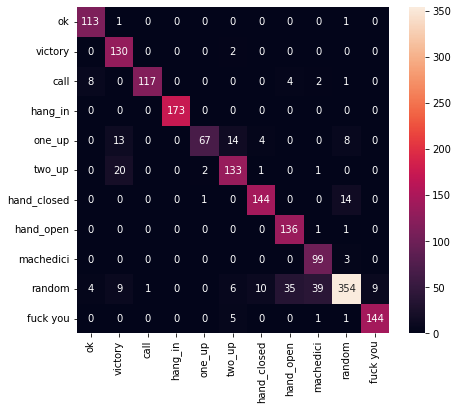

Classification Report
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94       115
         1.0       0.75      0.98      0.85       132
         2.0       0.99      0.89      0.94       132
         3.0       1.00      1.00      1.00       173
         4.0       0.96      0.63      0.76       106
         5.0       0.83      0.85      0.84       157
         6.0       0.91      0.91      0.91       159
         7.0       0.78      0.99      0.87       138
         8.0       0.69      0.97      0.81       102
         9.0       0.92      0.76      0.83       467
        10.0       0.94      0.95      0.95       151

    accuracy                           0.88      1832
   macro avg       0.88      0.90      0.88      1832
weighted avg       0.89      0.88      0.88      1832



In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, dict_keys=None, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    if dict_keys:
        labels = [dict_keys[x] for x in labels]

    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred, {v: k for k, v in classes.items()})

In [15]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/3w/bsb667zn42gdhbqq3z8ptmgw0000gn/T/tmp0ur8c5m2/assets


2022-07-30 17:09:42.348883: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-07-30 17:09:42.348900: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-07-30 17:09:42.349931: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/3w/bsb667zn42gdhbqq3z8ptmgw0000gn/T/tmp0ur8c5m2
2022-07-30 17:09:42.352215: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2022-07-30 17:09:42.352232: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/3w/bsb667zn42gdhbqq3z8ptmgw0000gn/T/tmp0ur8c5m2
2022-07-30 17:09:42.357161: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-07-30 17:09:42.358888: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-07-30 17:09:42.427514: I tensorflow/cc/saved_model/loader.

8040

Inference test

In [16]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [17]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 116 µs, sys: 48 µs, total: 164 µs
Wall time: 149 µs


In [18]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.7063590e-05 1.6513423e-04 1.0740484e-05 1.8660815e-10 2.2817042e-03
 7.7829340e-05 6.8759853e-01 3.8016873e-04 1.4390363e-03 3.0795476e-01
 7.5038501e-05]
6


In [19]:
classes

{'ok': 0,
 'victory': 1,
 'call': 2,
 'hang_in': 3,
 'one_up': 4,
 'two_up': 5,
 'hand_closed': 6,
 'hand_open': 7,
 'machedici': 8,
 'random': 9,
 'fuck you': 10}